**Machine Learning for Time Series (Master MVA)**

- TP1, Thursday 18<sup>th</sup> October 2023
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

**Ben Kabongo B.**

# Introduction

In this notebook, we illustrate two concepts:
- convolutional dictionary learning (CDL),
- dynamic time warping (DTW).

## Setup

**Import**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from IPython.display import Audio, display
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.colors import rgb2hex
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

from alphacsc import learn_d_z
from alphacsc.utils.convolution import construct_X

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [3]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

In [4]:
def get_n_largest(arr: np.ndarray, n_largest: int = 3) -> tuple:
    """Return the n largest values and associated indexes of an array.

    (In decreasing order of value.)
    """
    indexes = np.argsort(arr)[-n_largest:][::-1]
    if n_largest == 1:
        indexes = np.array(indexes)
    values = np.take(arr, indexes)
    return values, indexes

In [5]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

# Convolutional dictionary learning (CDL)

## Data

In [6]:
BASE_PATH = "./data/"
dataset_name = "BinaryHeartbeat"
#data = load_uea_ucr_data(dataset_name)
#print(data.description)
X_train = np.loadtxt(BASE_PATH + "BinaryHeartbeat.csv").reshape((204, 18530, 1))
print(X_train.shape)

(204, 18530, 1)


In [7]:
y_train = np.loadtxt(BASE_PATH + "BinaryHeartbeat_label.txt", dtype=str)
y_train.shape

(204,)

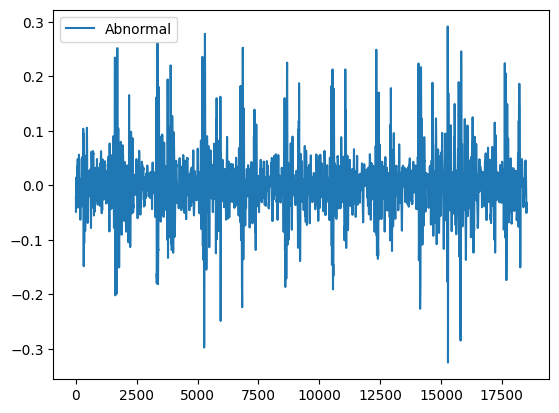

In [8]:
plt.plot(X_train[0], label=y_train[0])
plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the sampling frequency of those sounds?</p>
</div>

In [9]:
FREQUENCY = 2000  # Hz

We can plot a signal from each class (normal and abnormal).

Training set:	204 time series with 18530 samples and 1 dimension.



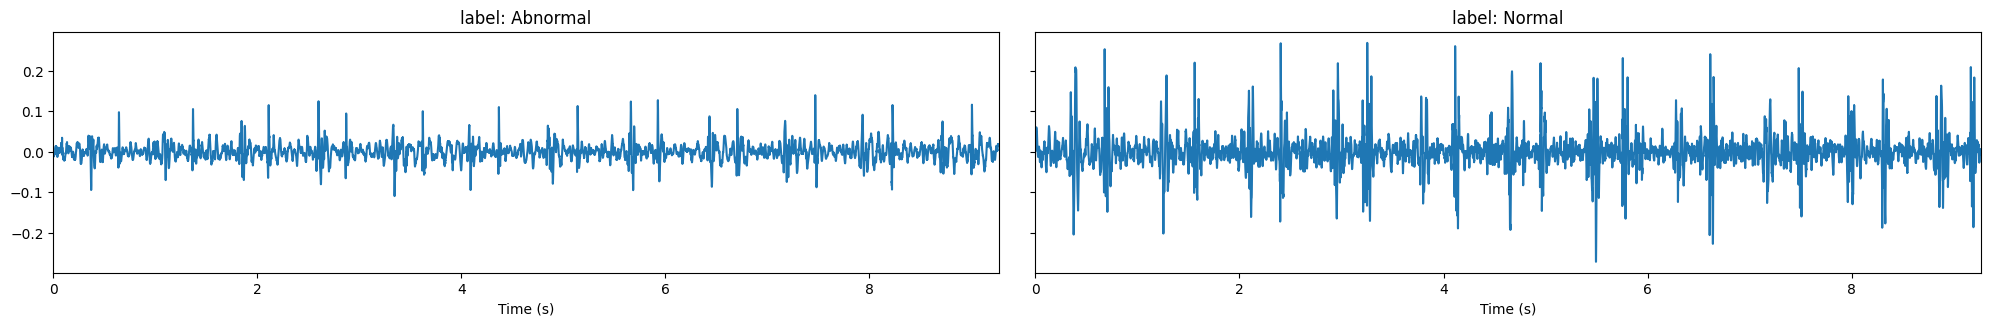

In [10]:
msg = "{title} set:\t{n_series} time series with {n_samples} samples and {n_dims} dimension."
n_series, n_samples, n_dims = X_train.shape
print(
    msg.format(
        title="Training", n_series=n_series, n_samples=n_samples, n_dims=n_dims
    )
)
print()

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([1, 200], ax_arr):
    s = X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    _ = ax.set_title(f"label: {y_train[ind]}")

In [11]:
# Since the time series are sound signals, we can choose one and listen to it.

for ind in [1, 200]:
    signal = X_train[ind]
    label = y_train[ind]
    print(label)
    display(Audio(signal.flatten(), rate=FREQUENCY))

Abnormal


Normal


For the subsequent study, we select only 6 elements (3 from each classe) from the complete data set.

In [12]:
sub_sample = [0, 1, 2, 190, 191, 192]  # 3 Normal, 3 Abnormal
X = np.take(
    X_train, sub_sample, axis=0
).squeeze()  # shape (n_series, n_samples)
y = np.take(y_train, sub_sample, axis=0)  # shape (n_series,)

# normalize signals (zero mean, unit variance).
X -= X.mean(axis=1).reshape(-1, 1)
X /= X.std(axis=1).reshape(-1, 1)

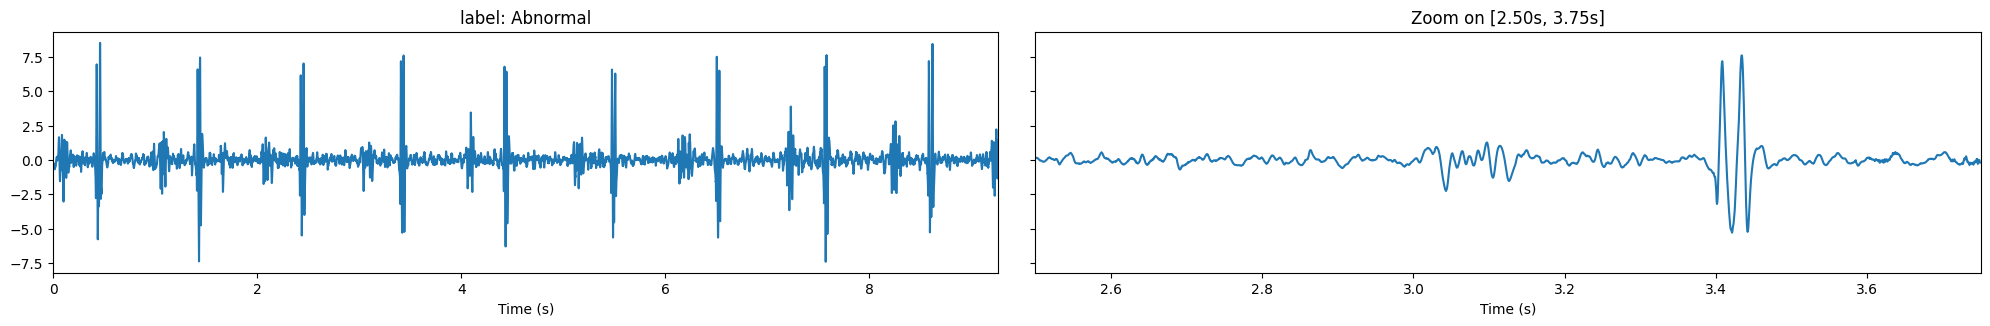

In [13]:
ind = 2
signal = X[ind]
label = y[ind]

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
ax = ax_arr[0]

n_samples = signal.size
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)
ax.set_xlabel("Time (s)")
ax.set_xlim(0, n_samples / FREQUENCY)

ax.set_title(f"label: {label}")

ax = ax_arr[1]
start, end = 5000, 7500  # change here to zoom somewhere else
ax.plot(tt[start:end], signal[start:end])
ax.set_xlim(tt[start], tt[end])
ax.set_xlabel("Time (s)")
_ = ax.set_title(f"Zoom on [{start/FREQUENCY:.2f}s, {end/FREQUENCY:.2f}s]")

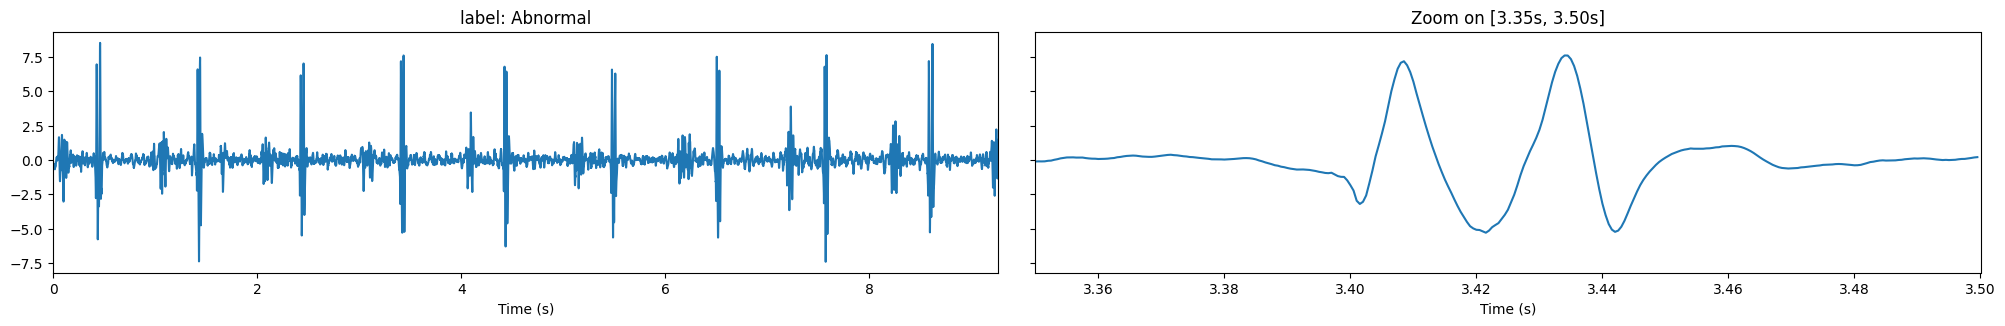

In [14]:
ind = 2
signal = X[ind]
label = y[ind]

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
ax = ax_arr[0]

n_samples = signal.size
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)
ax.set_xlabel("Time (s)")
ax.set_xlim(0, n_samples / FREQUENCY)

ax.set_title(f"label: {label}")

ax = ax_arr[1]
start, end = 6700, 7000  # change here to zoom somewhere else
ax.plot(tt[start:end], signal[start:end])
ax.set_xlim(tt[start], tt[end])
ax.set_xlabel("Time (s)")
_ = ax.set_title(f"Zoom on [{start/FREQUENCY:.2f}s, {end/FREQUENCY:.2f}s]")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Roughly, what is the duration of the important phenomenon (the heartbeat)?</p>
</div>

Le battement de coeur dure 44 secondes.

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N$ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad (1/2)\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$$

where $\mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the parameters that a user must calibrate when using CDL?</p>
</div>

- `K nombre des motifs`
- `L taille des motifs`
- $\lambda$ `régularisation`

We can now apply CDL on a single signal.

In [15]:
# Select a signal
signal = X[2]
data = signal[np.newaxis, :]  # shape (1, n_samples)

In [16]:
# Parameters to change
n_atoms = 5  # K
atom_length = 500  # L
penalty = 3  # lambda

In [17]:
%%time
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=signal[None, :],
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=4,
    verbose=1)

V_0/30 .............................
CPU times: user 1min 17s, sys: 8.03 s, total: 1min 25s
Wall time: 17.2 s


In [18]:
d_hat.shape, z_hat.shape

((5, 500), (5, 1, 18031))

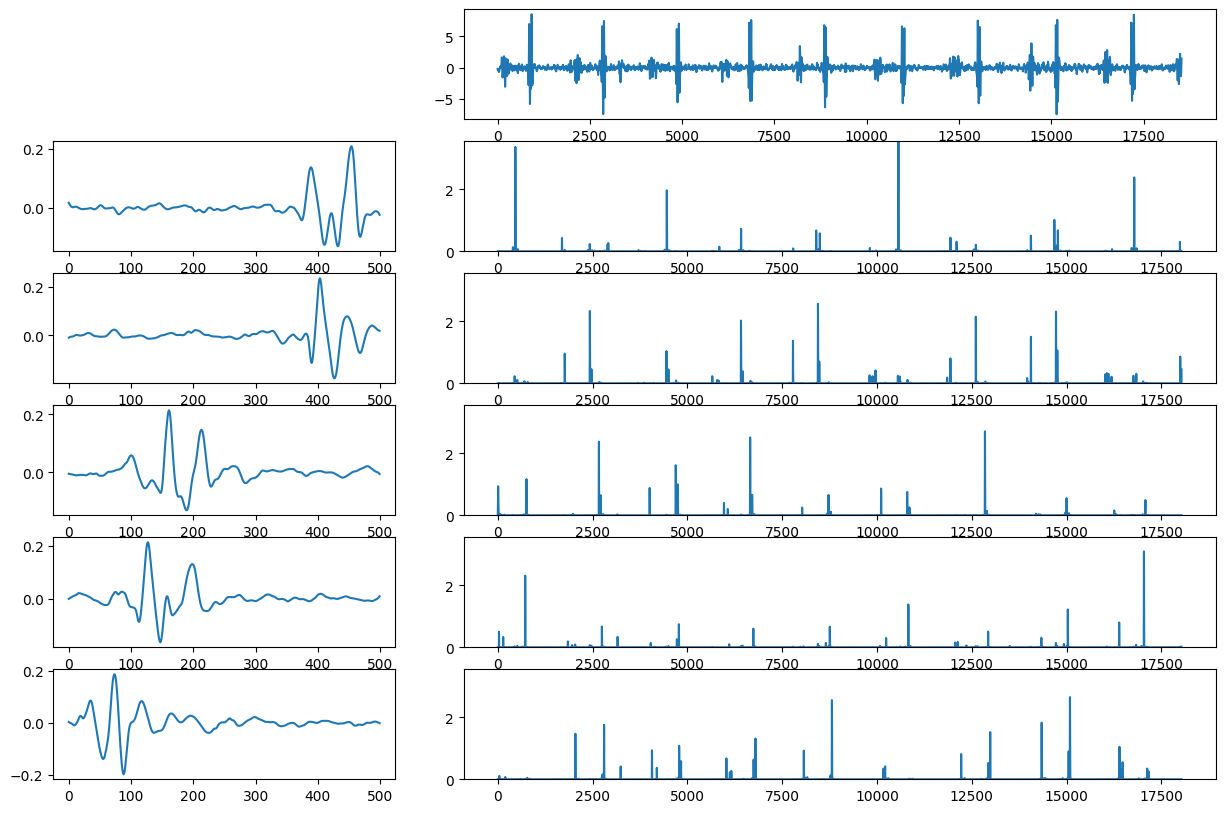

In [19]:
# plot the results
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does the number of activation evolve when the sparsity penalty changes?</p>
</div>

`Comme on fait de la régularisation Lasso, si le coefficient de penalisation augmente alors le nombre d'activations baisse.`

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Looking at the sparse codes, can you tell:</p>
    <ul>    
    <li>How many times each atom is activated?</li>
    <li>What is the compression rate (number of non-zero coefficients in the sparse codes / signal length)?</li>
    </ul>
</div>

In [20]:
n_activations = (z_hat.squeeze() > 0).sum(1)
compression_rate = 1-(np.count_nonzero(z_hat.squeeze()) / z_hat.size)

print("Number of activations for each atom :", n_activations)
print(f"Compression rate : {compression_rate:.2f}")

Number of activations for each atom : [1647 2020 1499 2078 2164]
Compression rate : 0.90


Listen to the learned dictionary.

In [21]:
for k, atom in enumerate(d_hat):
    print(f"Atom {k}")
    display(Audio(atom, rate=FREQUENCY))

Atom 0


Atom 1


Atom 2


Atom 3


Atom 4


Now, let us look at the reconstruction error.

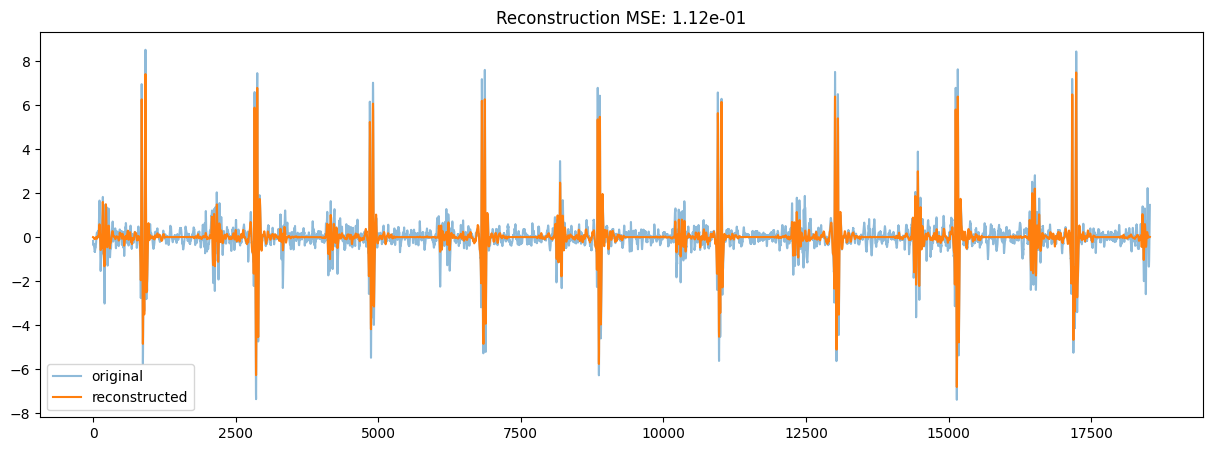

In [22]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = construct_X(z_hat, d_hat).squeeze()

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt, reconstruction, label="reconstructed")

ax.set_title(f"Reconstruction MSE: {np.mean((signal - reconstruction)**2):.2e}")

_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does reconstruction error evolve when the sparsity penalty changes?</p>
</div>

`L'erreur de reconstruction sera plus grande avec un plus grand lambda.`

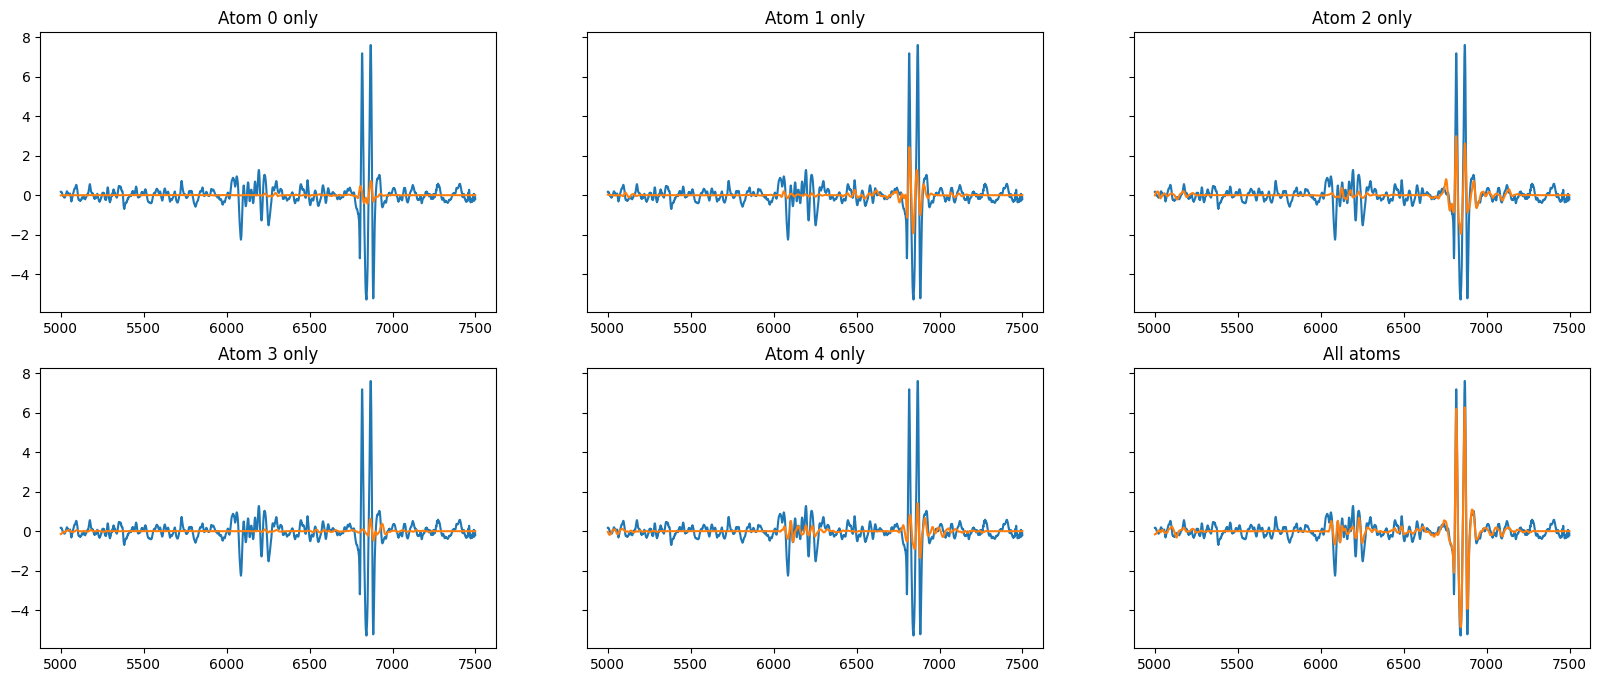

In [23]:
start, end = 5000, 7500

fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k in range(n_atoms):
    ax = ax_arr.flatten()[k]
    reconstruted_with_one_atom = construct_X(
        z_hat[k, np.newaxis, :, :], d_hat[k, np.newaxis, :]
    ).squeeze()
    ax.plot(range(start, end), signal[start:end])
    ax.plot(
        range(start, end),
        reconstruted_with_one_atom[start:end],
    )
    ax.set_title(f"Atom {k} only")

ax = ax_arr.flatten()[n_atoms]
ax.plot(range(start, end), signal[start:end])
ax.plot(
    range(start, end),
    reconstruction[start:end],
)
_ = ax.set_title(f"All atoms")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Rerun the dictionary learning and sparse coding. What do you observe on the motif shape? And the reconstruction error?</p>
</div>

Les résultats ne sont pas les mêmes, le problème d'optimisation n'étant pas convexe et l'initialisation différente à chaque lancement.

## CDL on the whole data set

In this section, we apply CDL on the whole data set.

In [24]:
# In the following, we fix the number of atoms and their length
n_atoms = 5
atom_length = 1500
penalty = 4

Dictionary learning.

In [25]:
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=X,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    verbose=1,
    n_jobs=8,
    n_iter=30,
)

V_0/30 .............................


Let us plot each of the learned atoms.

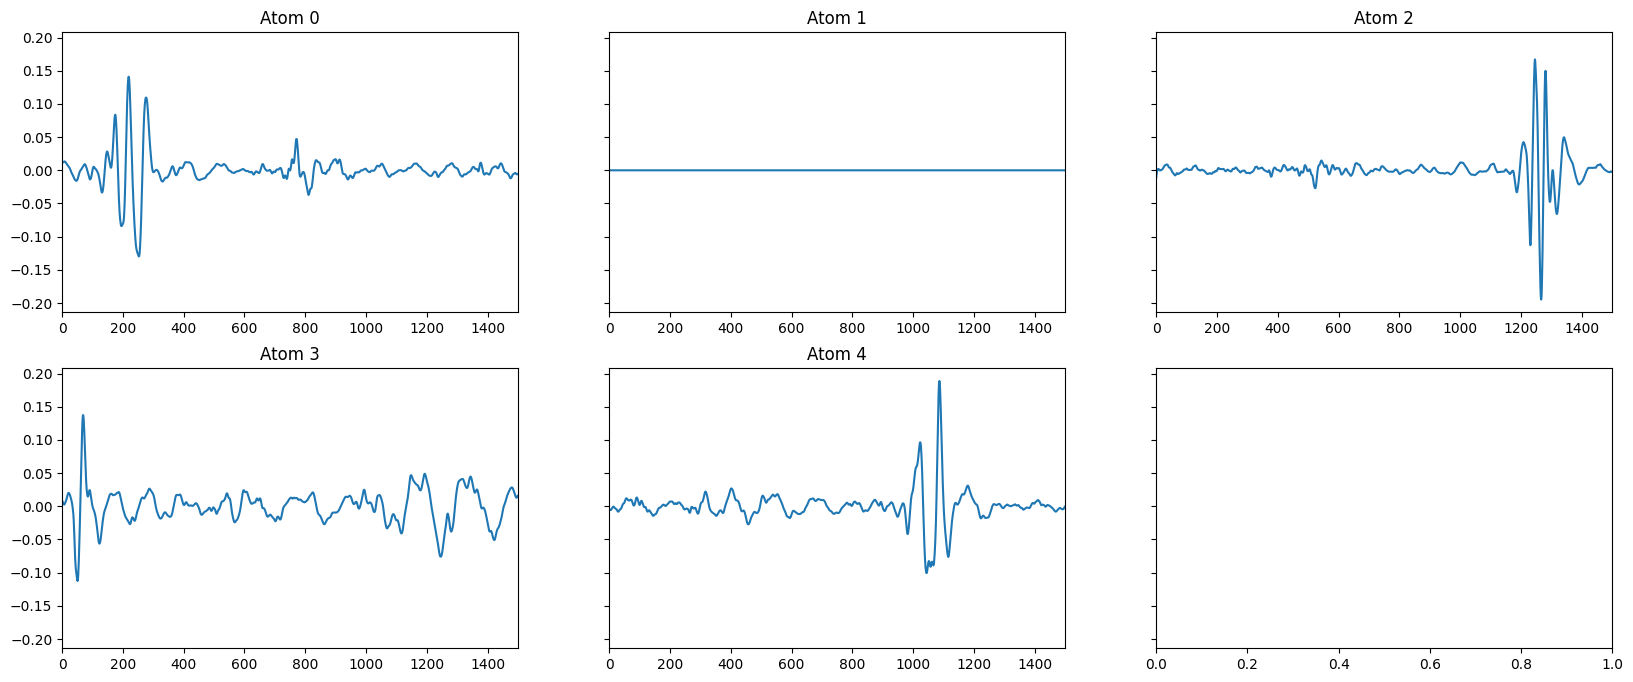

In [26]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k, (atom, ax) in enumerate(zip(d_hat, ax_arr.flatten())):
    ax.plot(atom)
    ax.set_xlim(0, atom.size)
    ax.set_title(f"Atom {k}")

For each signal of the data set, we compute the number of non-zeros activations and the reconstruction error.

In [27]:
for k, (label, signal) in enumerate(zip(y, X)):
    codes = z_hat[:, k, :]
    reconstruction = construct_X(codes[:, np.newaxis, :], d_hat).squeeze()
    error = np.mean((signal - reconstruction) ** 2)
    nnz_activations = (codes > 1e-3).sum()

    # select the used atoms
    most_used_atoms_activations, most_used_atoms_indexes = get_n_largest(
        (codes > 1e-3).sum(axis=1), n_largest=1
    )
    most_used_atom_msg = ", ".join(
        f"{ind} ({acti*100/nnz_activations:.1f}%)"
        for (acti, ind) in zip(
            most_used_atoms_activations, most_used_atoms_indexes
        )
    )
    print(
        f"Label: {label}, MSE: {error:.2f}, non-zero activations: {nnz_activations}, most used atoms: {most_used_atom_msg}"
    )

Label: Abnormal, MSE: 0.32, non-zero activations: 6454, most used atoms: 3 (29.4%)
Label: Abnormal, MSE: 0.30, non-zero activations: 8977, most used atoms: 3 (35.0%)
Label: Abnormal, MSE: 0.22, non-zero activations: 5114, most used atoms: 0 (26.2%)
Label: Normal, MSE: 0.36, non-zero activations: 7605, most used atoms: 3 (30.3%)
Label: Normal, MSE: 0.25, non-zero activations: 3424, most used atoms: 0 (26.6%)
Label: Normal, MSE: 0.20, non-zero activations: 8206, most used atoms: 4 (27.9%)


Using the `Audio` function, we can listen to the learned dictionary and the reconstructed signals.

In [28]:
for k, (label, signal) in enumerate(zip(y, X)):
    codes = z_hat[:, k, :]
    reconstruction = construct_X(codes[:, np.newaxis, :], d_hat).squeeze()

    print(label)
    print("\tOriginal", end=" ")
    display(Audio(signal.flatten(), rate=FREQUENCY))
    print("\tReconstruction", end=" ")
    display(Audio(reconstruction, rate=FREQUENCY))

Abnormal
	Original 

	Reconstruction 

Abnormal
	Original 

	Reconstruction 

Abnormal
	Original 

	Reconstruction 

Normal
	Original 

	Reconstruction 

Normal
	Original 

	Reconstruction 

Normal
	Original 

	Reconstruction 

The noise has been removed. For the worst approximated signal, some hearbeats have been skipped.

# Distance between signals (DTW)

## Data

In [29]:
dataset_name = "FiftyWords"
#data = load_uea_ucr_data(dataset_name)
#print(data.description)
profiles = np.loadtxt(BASE_PATH + "dtw_X_train.csv").reshape((450, 270, 1))
print(profiles.shape)

(450, 270, 1)


In [30]:
labels = np.loadtxt(BASE_PATH + "dtw_y_train.txt", dtype=str)
print(labels.shape)

(450,)


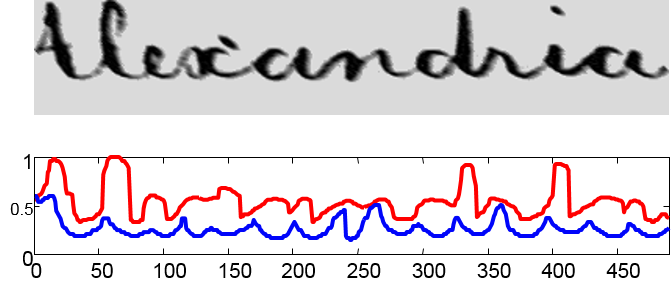

Here, we only deal with the top profile (in red).

In [31]:
# normalize signals (zero mean, unit variance).
profiles -= profiles.mean(axis=1).reshape(-1, 1, 1)
profiles /= profiles.std(axis=1).reshape(-1, 1, 1)

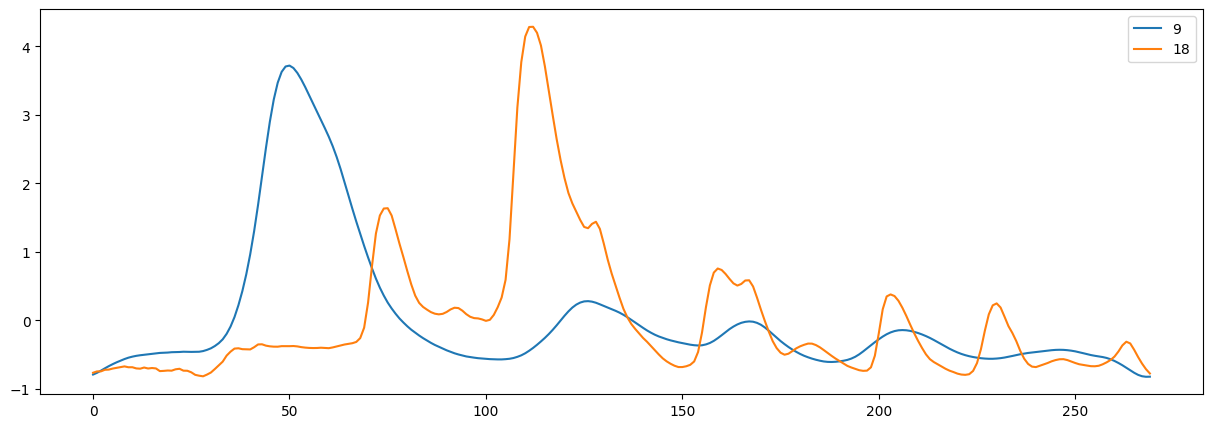

In [32]:
word_1, label_1 = profiles[0].flatten(), labels[0]
word_2, label_2 = profiles[1].flatten(), labels[1]
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
_ = plt.legend()

## DTW between two signals

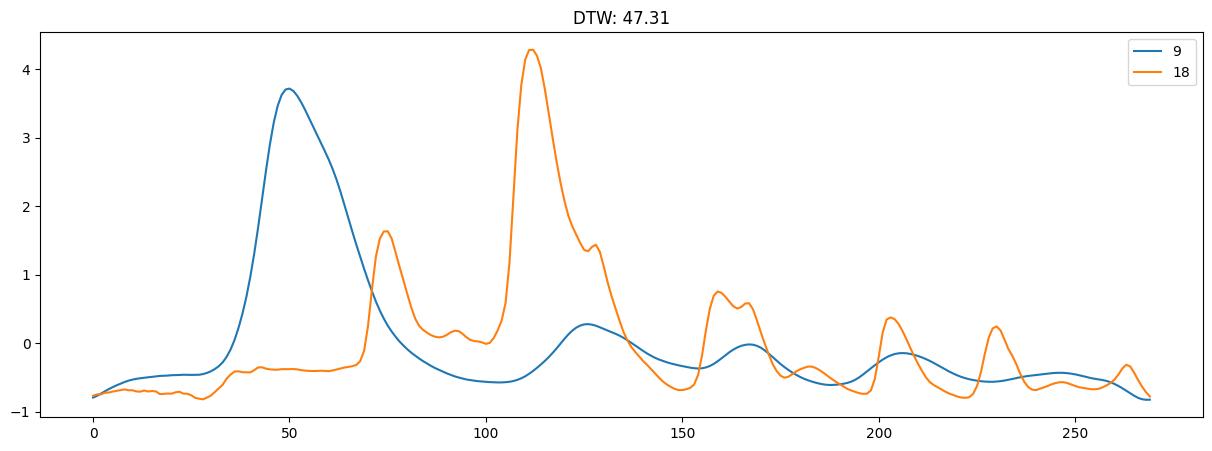

In [33]:
alignment = dtw(word_1, word_2, keep_internals=True)
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
plt.title(f"DTW: {alignment.distance:.2f}")
_ = plt.legend()

<AxesSubplot: >

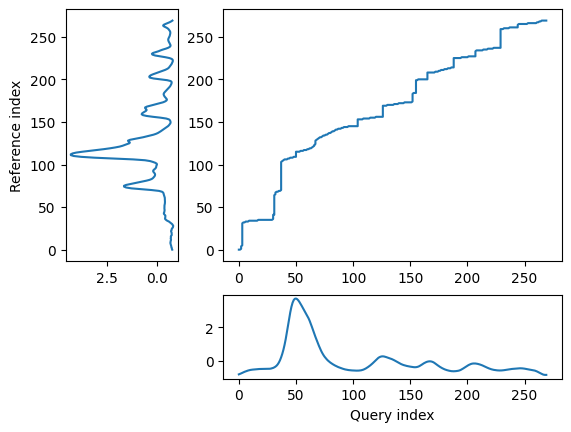

In [34]:
alignment.plot(type="threeway")

<AxesSubplot: xlabel='Index', ylabel='Query value'>

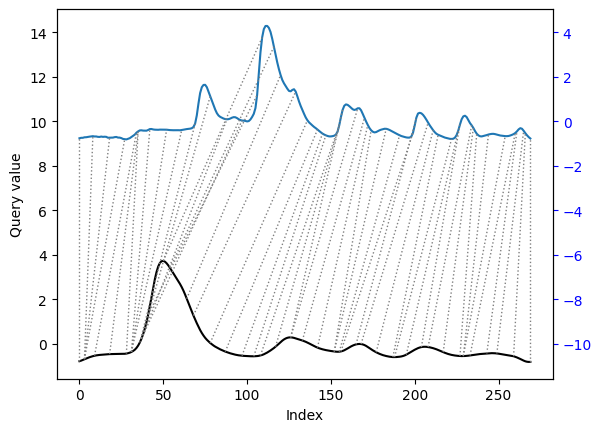

In [35]:
alignment.plot(type="twoway", offset=10)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Write a function  which computes the DTW distance between two signals: <tt>get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float</tt>.</p>
</div>

In [36]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float:
    return dtw(signal_1, signal_2, keep_internals=True).distance

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Choose a word and plot the most similar and the most dissimilar, according to the DTW. In addition, print the associated labels.</p>
</div>

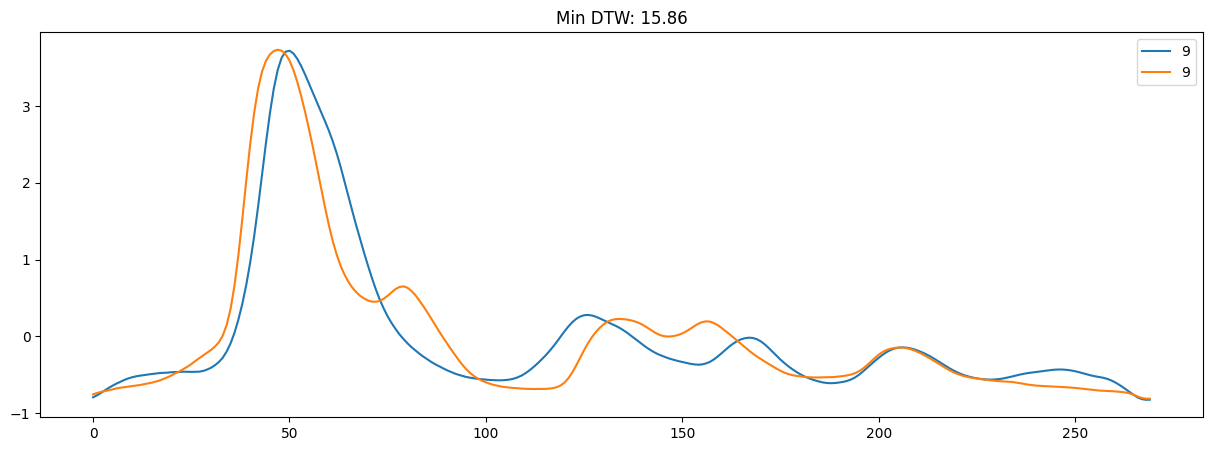

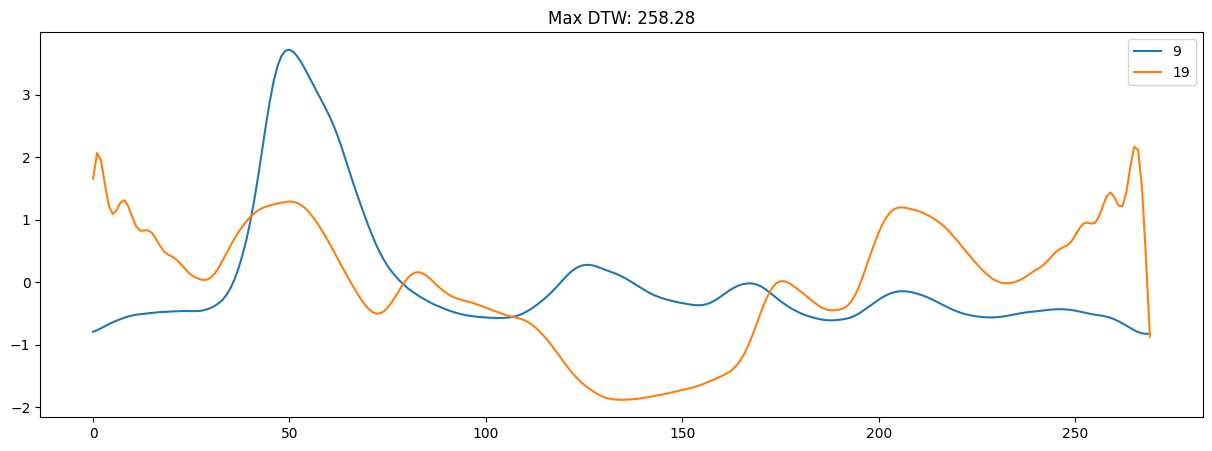

In [37]:
word, label = profiles[0].flatten(), labels[0]
min_dtw = +np.inf
max_dtw = 0
min_word_idx = -1
max_word_idx = -1
for i in range(1, len(profiles)):
    d = get_dtw_distance(word, profiles[i])
    if d < min_dtw:
        min_word_idx = i
        min_dtw = d
    if d > max_dtw:
        max_word_idx = i
        max_dtw = d

fig, ax = fig_ax()
ax.plot(word, label=label)
ax.plot(profiles[min_word_idx], label=labels[min_word_idx])
plt.title(f"Min DTW: {min_dtw:.2f}")
_ = plt.legend()

fig, ax = fig_ax()
ax.plot(word, label=label)
ax.plot(profiles[max_word_idx], label=labels[max_word_idx])
plt.title(f"Max DTW: {max_dtw:.2f}")
_ = plt.legend()

## Clustering with DTW

### Clustering a small subset

Out of the whole data set, let us choose 6 word profiles from 2 classes.

In [38]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["31", "34"])
labels_sub = labels[keep_mask]
profiles_sub = profiles[keep_mask]
# reorder by label
order_indexes = labels_sub.argsort()
labels_sub = labels_sub[order_indexes]
profiles_sub = profiles_sub[order_indexes]

Compute the distance matrix $D$ of this smaller data set: $D_{ij} = d(x_i, x_j)$.

In [39]:
# init
distance_matrix = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix[row, col] = get_dtw_distance(
            profiles_sub[row], profiles_sub[col]
        )
        distance_matrix[col, row] = distance_matrix[row, col]

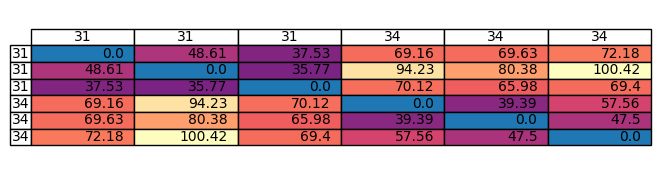

In [40]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2), labels=labels_sub
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Create the same plot (distance matrix) with the Euclidean distance instead of the DTW. What do you observe?</p>
</div>

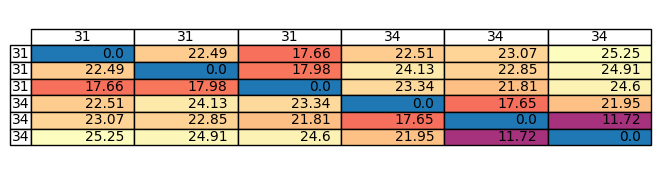

In [41]:
distance_matrix_euclidienne = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix_euclidienne[row, col] = np.sqrt(((profiles_sub[row] - profiles_sub[col]) ** 2).sum())
        distance_matrix_euclidienne[col, row] = distance_matrix_euclidienne[row, col]
_ = display_distance_matrix_as_table(
    np.round(distance_matrix_euclidienne, 2), labels=labels_sub
)

### Clustering on a larger subset

Using the DTW, we can cluster a large set of data (43 words).

In [42]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["4", "6", "14"])
profiles_sub = profiles[keep_mask]
labels_sub = labels[keep_mask]

Compute the distance matrix with the DTW.

In [43]:
# Instead of the previous double for loop, we can use scipy function pdist
distance_matrix = pdist(
    profiles_sub.squeeze(), metric=get_dtw_distance
)  # condensed distance matrix
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(distance_matrix)

Plot the linkage as a dendogram.

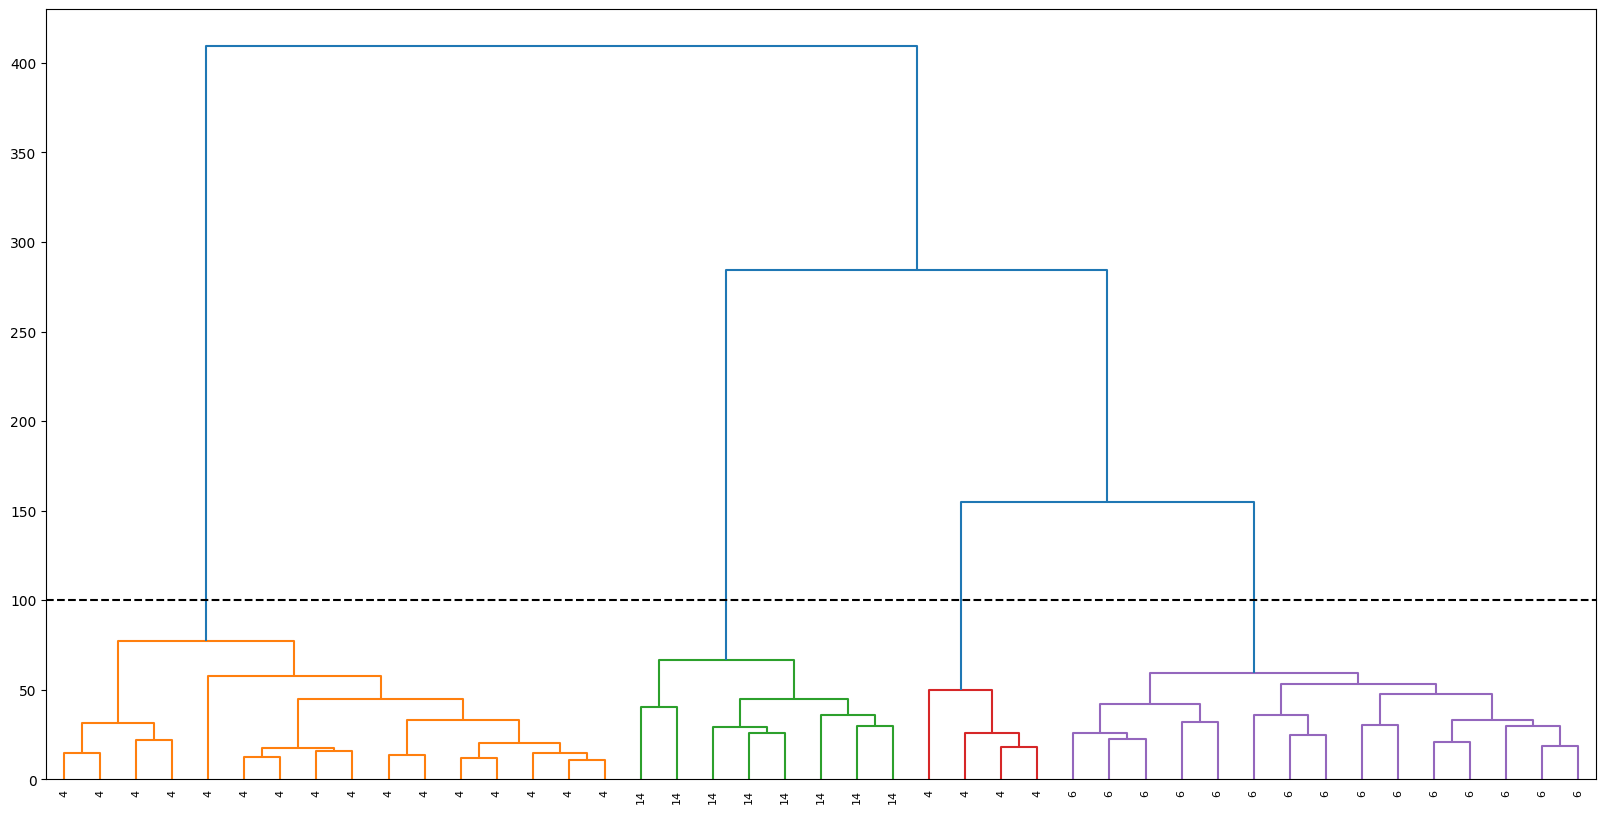

In [44]:
fig, ax = fig_ax((20, 10))

cut_threshold = 100

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

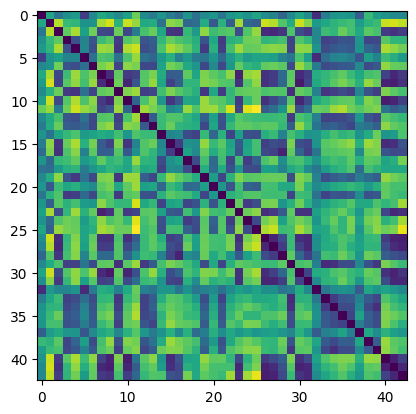

In [45]:
plt.imshow(squareform(distance_matrix))

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same clustering with the Euclidean distance instead. Plot the linkage as a dendogram.</p>
</div>

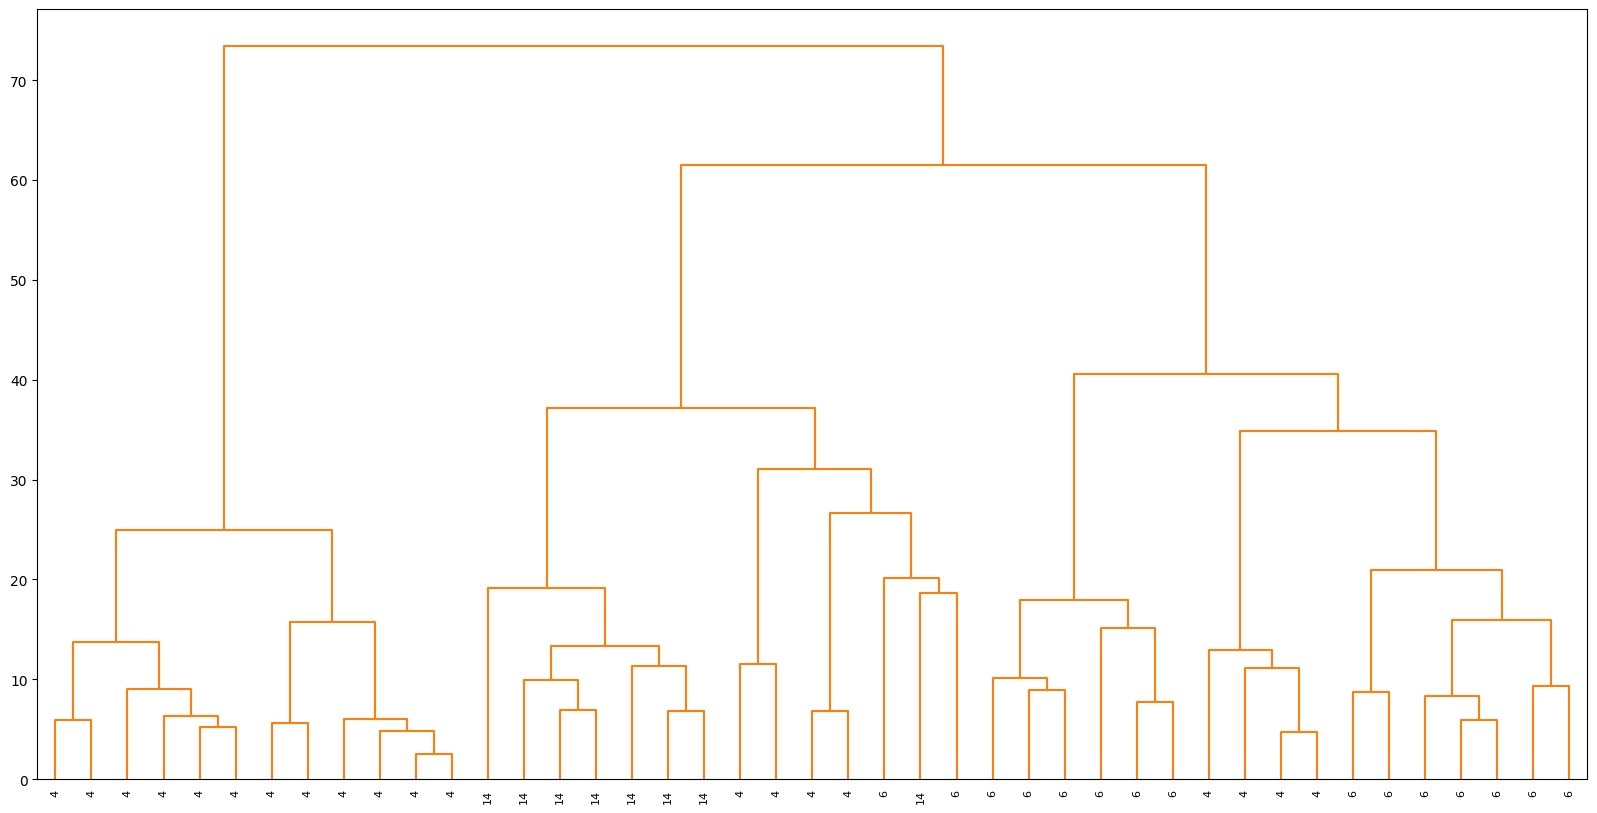

In [46]:
euclidienne_distance = lambda a, b: np.sqrt(((a-b)**2).sum())
distance_matrix_euclidienne = pdist(
    profiles_sub.squeeze(), metric=euclidienne_distance
)
linkage = hierarchy.ward(distance_matrix_euclidienne)
fig, ax = fig_ax((20, 10))
cut_threshold = 100
dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

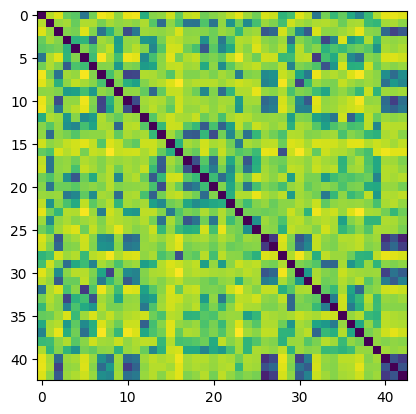

In [47]:
plt.imshow(squareform(distance_matrix_euclidienne))

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous dendrograms, change the <tt>cut_threshold</tt> argument to have homogeneous clusters (as much as possible).</p>
</div>

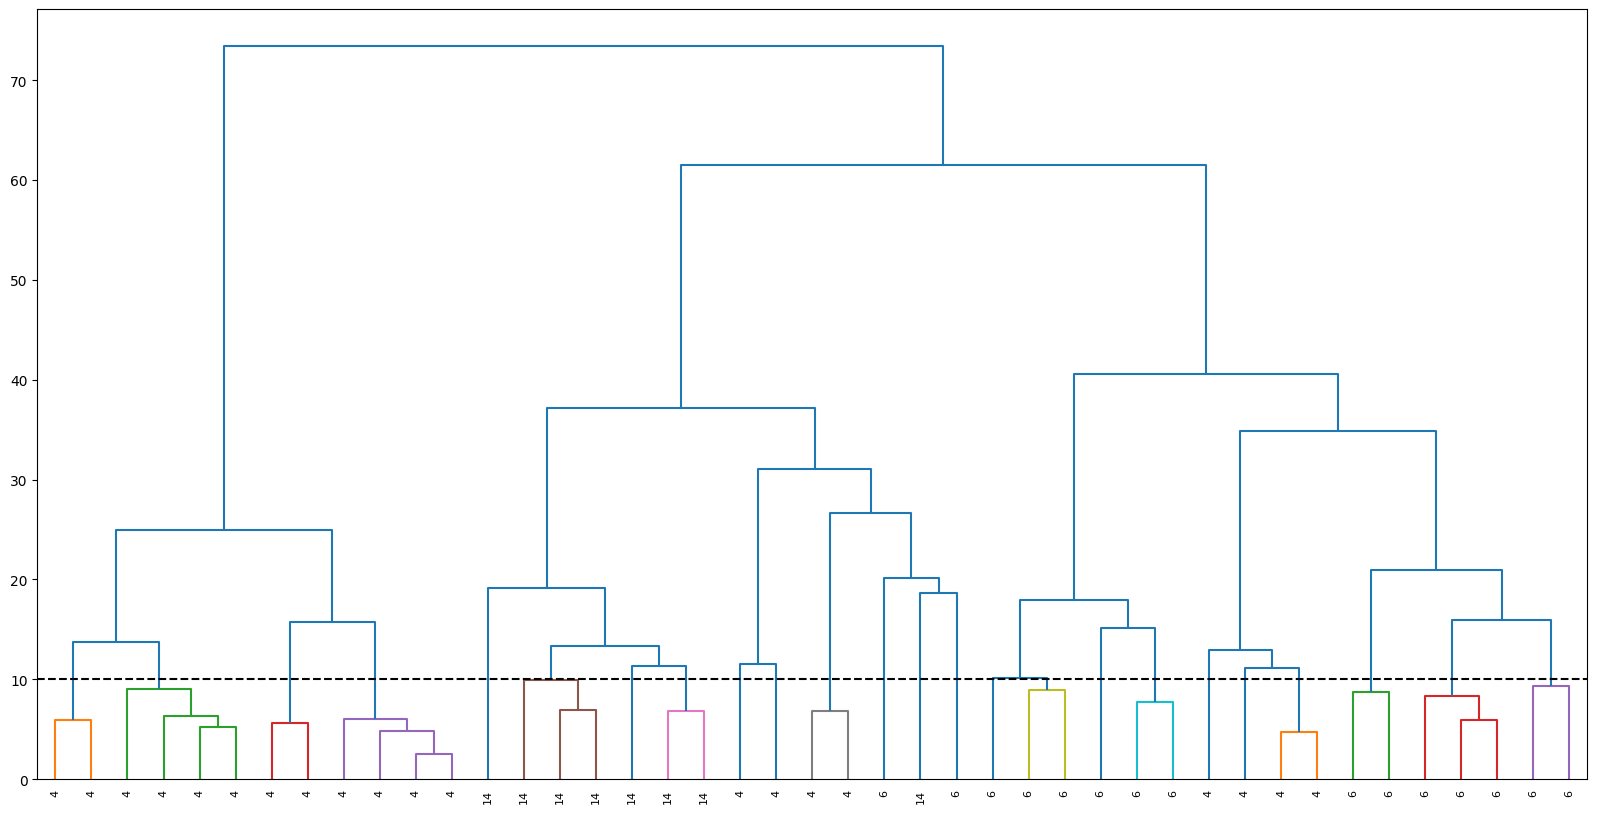

In [48]:
euclidienne_distance = lambda a, b: np.sqrt(((a-b)**2).sum())
distance_matrix_euclidienne = pdist(
    profiles_sub.squeeze(), metric=euclidienne_distance
)
linkage = hierarchy.ward(distance_matrix_euclidienne)
fig, ax = fig_ax((20, 10))
cut_threshold = 10
dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")